# 1分足データで、ある足からN足「以内」に上昇する確率の分析
- 全期間でN足以内に上昇する確率
- 1年毎でN足以内に上昇する確率
- N足以内にX%以上上昇する確率

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-01min.csv')

# 月次データ（1年ごとの価格変化を見るため）
#df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

In [3]:
df_sp_raw

,Date,Time,Open,High,Low,Close,Up,Down
0,09/11/1997,04:34,1082.25,1082.25,1080.50,1080.50,4,0
1,09/11/1997,04:35,1079.75,1079.75,1079.75,1079.75,1,0
2,09/11/1997,05:46,1079.25,1079.25,1079.25,1079.25,1,0
3,09/11/1997,08:09,1078.75,1078.75,1078.75,1078.75,1,0
4,09/11/1997,08:10,1078.50,1078.50,1078.50,1078.50,2,0
...,...,...,...,...,...,...,...,...
6596587,05/29/2020,16:56,3056.00,3056.75,3055.75,3056.75,160,53
6596588,05/29/2020,16:57,3056.75,3057.25,3056.50,3057.25,135,98
6596589,05/29/2020,16:58,3057.00,3057.25,3056.50,3057.00,79,169
6596590,05/29/2020,16:59,3057.25,3057.50,3057.00,3057.00,160,155


# 分析用データ作成

In [4]:
# 年の列を追加
df_sp_raw['DT'] = (df_sp_raw['Date'] + '-' + df_sp_raw['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
df_sp_raw['year'] = df_sp_raw['DT'].map(lambda x: x.year)

# 年の順序づけ
min_year = df_sp_raw['year'].min()
max_year = df_sp_raw['year'].max()
year_type = CategoricalDtype(categories=[y for y in range(min_year, max_year+1)], ordered=True)
df_sp_raw['year'] = df_sp_raw['year'].astype(year_type)

In [5]:
df = df_sp_raw.copy()

# 何足分まで見れるようにするか
MAX_NBARS = 30
df = fl.make_nbars(df, MAX_NBARS, cols=['Close', 'Open'], datetime_col=None)

<ipython-input-5-293ada87b9cd>:5: DeprecationWarning: Function 'finalib.finalib.make_nbars()' has moved to 'finalib.finalib.make_nbars_past()'
  df = fl.make_nbars(df, MAX_NBARS, cols=['Close', 'Open'], datetime_col=None)


In [6]:
df.head(1)

,Date,Time,Open30,High,Low,Close30,Up,Down,DT,year,...,Close4,Open4,Close3,Open3,Close2,Open2,Close1,Open1,Close0,Open0
0,09/11/1997,04:34,1082.25,1082.25,1080.5,1080.5,4,0,1997-09-11 04:34:00,1997,...,1075.25,1075.25,1074.75,1074.75,1075.0,1075.0,1074.75,1074.75,1075.75,1075.75


# 全期間で、N足以内に上昇する確率

In [7]:
for n in reversed(range(MAX_NBARS+1)):
    df[f'CODiff{n}'] = df[f'Close{n}'] - df[f'Open{MAX_NBARS}']
    df[f'isUp{n}'] = reduce(lambda x,y: x | y, [df[f'CODiff{i}'] > 0 for i in range(n, MAX_NBARS+1)])
    df[f'isFlat{n}'] = reduce(lambda x,y: x & y, [df[f'CODiff{i}'] == 0 for i in range(n, MAX_NBARS+1)])
    df[f'isDown{n}'] = reduce(lambda x,y: x | y, [df[f'CODiff{i}'] < 0 for i in range(n, MAX_NBARS+1)])

In [8]:
for n_rev in range(MAX_NBARS+1):
    n = MAX_NBARS - n_rev
    print(f'\n{n_rev}足以内に価格が動く確率')
    print(f"P(UP) = {df[f'isUp{n}'].sum()} / {df.shape[0]} = {df[f'isUp{n}'].sum() / df.shape[0] * 100}%")
    print(f"P(FLAT) = {df[f'isFlat{n}'].sum()} / {df.shape[0]} = {df[f'isFlat{n}'].sum() / df.shape[0] * 100}%")
    print(f"P(DOWN) = {df[f'isDown{n}'].sum()} / {df.shape[0]} = {df[f'isDown{n}'].sum() / df.shape[0] * 100}%")


0足以内に価格が動く確率
P(UP) = 1996685 / 6596562 = 30.268570203690953%
P(FLAT) = 2609801 / 6596562 = 39.563048145382396%
P(DOWN) = 1990076 / 6596562 = 30.16838165092665%

1足以内に価格が動く確率
P(UP) = 2968792 / 6596562 = 45.005140556550515%
P(FLAT) = 1135406 / 6596562 = 17.212087144788452%
P(DOWN) = 2951218 / 6596562 = 44.73872905310372%

2足以内に価格が動く確率
P(UP) = 3513490 / 6596562 = 53.262441859865795%
P(FLAT) = 565870 / 6596562 = 8.57825637051543%
P(DOWN) = 3490380 / 6596562 = 52.912107852545006%

3足以内に価格が動く確率
P(UP) = 3873442 / 6596562 = 58.71910246579961%
P(FLAT) = 308767 / 6596562 = 4.680726111571452%
P(DOWN) = 3844974 / 6596562 = 58.287544329910034%

4足以内に価格が動く確率
P(UP) = 4133739 / 6596562 = 62.66505188611886%
P(FLAT) = 179111 / 6596562 = 2.7152174117365986%
P(DOWN) = 4101826 / 6596562 = 62.18126957648544%

5足以内に価格が動く確率
P(UP) = 4332381 / 6596562 = 65.67634777024759%
P(FLAT) = 109210 / 6596562 = 1.6555593656210614%
P(DOWN) = 4298313 / 6596562 = 65.1598969281271%

6足以内に価格が動く確率
P(UP) = 4491097 / 6596562 = 6

In [9]:
def create_prob_data(df, nbars):
    df_prob = pd.DataFrame(columns=['NBars', 'up', 'flat', 'down'])
    for n_rev in range(nbars+1):
        n = nbars - n_rev
        p_up = df[f'isUp{n}'].sum() / df.shape[0] * 100
        p_flat = df[f'isFlat{n}'].sum() / df.shape[0] * 100
        p_down = df[f'isDown{n}'].sum() / df.shape[0] * 100
        df_prob = df_prob.append(pd.Series([n_rev, p_up, p_flat, p_down], index=df_prob.columns), ignore_index=True)

    return df_prob

df_prob = create_prob_data(df, MAX_NBARS)

Text(0, 0.5, 'percentage (%)')

<Figure size 432x288 with 0 Axes>

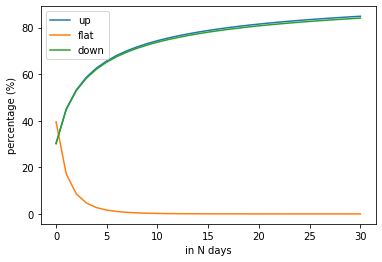

In [10]:
plt.figure()
df_prob[['up','flat','down']].plot()
plt.xlabel('in N days')
plt.ylabel('percentage (%)')

# 1年毎の推移

In [11]:
df['rowCount'] = 1 # 年毎の行数カウント用
cols = sum([[f'isUp{i}',f'isFlat{i}',f'isDown{i}'] for i in reversed(range(MAX_NBARS+1))],[]) + ['rowCount']
df_by_year = df.groupby('year')[cols].sum()
df_by_year.head(1)

,isUp30,isFlat30,isDown30,isUp29,isFlat29,isDown29,isUp28,isFlat28,isDown28,isUp27,...,isUp2,isFlat2,isDown2,isUp1,isFlat1,isDown1,isUp0,isFlat0,isDown0,rowCount
year,,,,,,,,,,,,,,,,,,,,,
1997,12722.0,16146.0,12435.0,20085.0,4708.0,19568.0,23558.0,1565.0,23037.0,25733.0,...,35761.0,12.0,35075.0,35856.0,11.0,35168.0,35941.0,10.0,35261.0,41303


In [12]:
# 30足以上終値が変化しなかったことがあった日
# サーキットブレーカーがおそらく発動した日
# そうじゃないのに変化しなかったこともわずかだがあった
set(df[df['isFlat0'] == True]['Date'])

{'01/22/2008',
 '03/02/2015',
 '03/08/2020',
 '03/09/2020',
 '03/13/2020',
 '03/15/2020',
 '03/16/2020',
 '03/17/2020',
 '03/18/2020',
 '03/22/2020',
 '03/24/2020',
 '06/24/2016',
 '08/31/2014',
 '09/03/2013',
 '09/20/2006',
 '10/10/2017',
 '10/23/1997',
 '10/24/2008',
 '11/08/2006',
 '12/15/2004',
 '12/22/2006'}

In [13]:
def create_prob_data_from_series(df, nbars):
    df_prob = pd.DataFrame(columns=['NBars', 'up', 'flat', 'down'])
    for n_rev in range(nbars+1):
        n = nbars - n_rev
        p_up = df[f'isUp{n}'] / df['rowCount'] * 100
        p_flat = df[f'isFlat{n}'] / df['rowCount'] * 100
        p_down = df[f'isDown{n}'] / df['rowCount'] * 100
        df_prob = df_prob.append(pd.Series([n_rev, p_up, p_flat, p_down], index=df_prob.columns), ignore_index=True)

    return df_prob

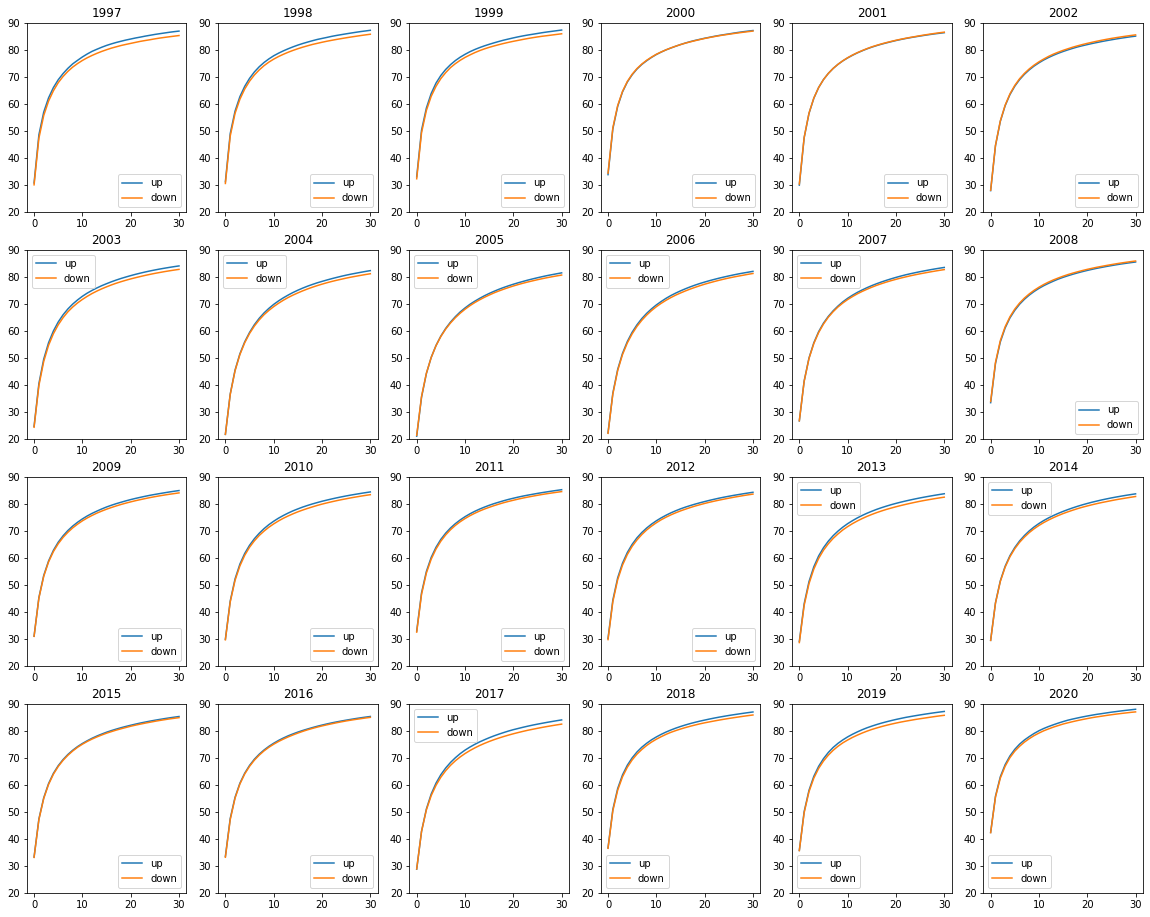

In [14]:
figcol, figrow = 4, 6
fig, ax = plt.subplots(figcol, figrow, figsize=(20, 16))
for i, (idx, row) in enumerate(df_by_year.iterrows()):
    fcol, frow = i // figrow, i % figrow
    df_prob_of_this_year = create_prob_data_from_series(row, MAX_NBARS)
    df_prob_of_this_year[['up','down']].plot(ax=ax[fcol,frow])
    ax[fcol,frow].set_ylim(20, 90)
    #ax[fcol,frow].set_xlabel('in N days')
    #ax[fcol,frow].set_ylabel('percentage (%)')
    ax[fcol,frow].set_title(idx)

In [21]:
# 2019年の統計
df_prob_of_2019 = create_prob_data_from_series(df_by_year.loc[2019,:], MAX_NBARS)
df_prob_of_2019
# 始値で仕掛けるとしたらn分以内に手仕舞うというのは (NBars-1) で手仕舞うことに相当する

,NBars,up,flat,down
0,0.0,35.679911,28.679158,35.640931
1,1.0,50.049442,9.688126,49.676547
2,2.0,57.933567,3.774818,57.442582
3,3.0,63.140350,1.609385,62.463062
4,4.0,66.827175,0.736906,66.059600
5,5.0,69.659865,0.355125,68.776495
6,6.0,71.945106,0.180286,70.955112
7,7.0,73.806432,0.091719,72.752235
8,8.0,75.326678,0.049872,74.242385
9,9.0,76.600142,0.024650,75.512409


In [23]:
df_by_year.loc[2019,['rowCount']]

rowCount    348891.0
Name: 2019, dtype: float64